In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import quad
from utils import LogisticMap, CosineKernel, LogisticMapSimulation
import sys
sys.path.append("../../")
from DynamicalSystems.koopman_regression import KernelRidgeRegression, ReducedRankRegression, PrincipalComponentRegression, RandomizedReducedRankRegression

[KeOps] Warning : Cuda libraries were not detected on the system ; using cpu only mode


In [74]:
N = 20
kernel = CosineKernel(N)
regularization_size = 50
tikhonov_regs = np.geomspace(1e-2, 1e1, num=regularization_size)

parameters = {
    'num_train_samples' :   100,
    'ranks' :               8,
    'tikhonov_regs':        tikhonov_regs,
    'estimators' :          [PrincipalComponentRegression, RandomizedReducedRankRegression, KernelRidgeRegression],
}

statistics = {
    'num_test_samples' : 100,
    'test_repetitions' : 1,
    'train_repetitions' : 50
}
simulation = LogisticMapSimulation(kernel, parameters, statistics, N = N)

Init: Transfer matrix: 100%|██████████| 21/21 [00:01<00:00, 13.44it/s]


In [75]:
_, tikhonov_regs, eigvals = simulation.run_eigs(backend='cpu')

KernelRidgeRegression: 100%|██████████| 50/50 [01:31<00:00,  1.83s/it]


In [76]:
true_evals = simulation.logistic._evals
num_to_compare = 3
delta = 1
true_evals = simulation._preprocess_eigs(true_evals)[delta:num_to_compare + delta]

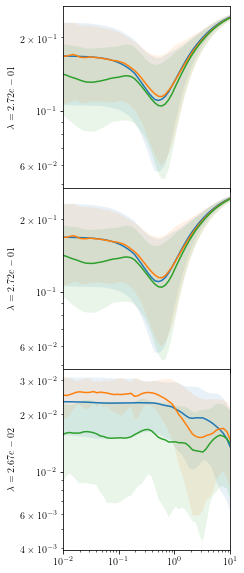

In [78]:
rank = parameters['ranks']
estimators = parameters['estimators']
num_above_threshold = 0
fig, axes = plt.subplots(num_to_compare, 1, sharex=True, figsize=(3,10))
ax_idx = -1
for ev_idx, ev in enumerate(true_evals):
    ax = axes[ev_idx]
    arg_mins = np.argmin(np.abs(eigvals - ev), axis=1)[:, None,...]
    mins = np.take_along_axis(eigvals, arg_mins, axis=1)
    mins -= ev
    for est_idx, estimator in enumerate(estimators):
        diff = np.abs(mins[:,0,est_idx,:])
        mean = diff.mean(axis=0)
        std = diff.std(axis=0)
        ax.fill_between(tikhonov_regs, mean - std, mean + std, alpha = 0.1)
        ax.plot(tikhonov_regs, mean, '-', label = estimator.__name__)
        ax.set_xmargin(0)
        #ax.legend(frameon=False)
    ax.set_ylabel(r"$\lambda = {:10.2e}$".format(np.abs(ev)))  
    ax.set_xscale('log')
    ax.set_yscale('log')
plt.subplots_adjust(hspace=0)